## Inicjalizacja środowiska programistycznego

In [2]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow  as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import logging
tf.get_logger().setLevel(logging.ERROR)

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

#import os
#os.chdir("/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/PL/")

#append path with python modules
import importlib
import sys
sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

## Rowery Kraków

**Zagadnienie:** przewidzieć liczbę rowerzystów na wybranej ulicy Krakowa na podstawie zliczeń z `window_size-1` poprzednich dni.

**Proszę:**

* pobrać dane używając komórki poniżej
* wypisać na ekran podsumowanie danych 

In [3]:
import pandas as pd

file_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTWNYLoE3k3JegSt47hV66v5j7_Vh8jIdLRUhcMLrIAW4VcIZK-3W9rGoDSfnToUnCIb9DPngGAlgL6/pub?gid=0&single=true&output=csv'
df = pd.read_csv(file_url)

df = pd.read_csv(file_url, sep=",",parse_dates=[0])
df = df.rename(columns={' ' : "Data"})
df = df.fillna(0)
df.index = df['Data']
df.drop(columns=['Data'], inplace=True)

#BEGIN_SOLUTION
print(df.describe())
#END_SOLUTION
pass

       Armii Krajowej  Bora-Komorowskiego      Bulwary  Grzegórzecka  \
count     2752.000000         2752.000000  2752.000000   2752.000000   
mean       325.617369          589.090480  1550.569767    683.259448   
std        509.777566          573.567019  1302.779035    899.223183   
min          0.000000            0.000000     0.000000      0.000000   
25%          0.000000           99.000000   433.000000      0.000000   
50%          0.000000          399.000000  1144.500000      0.000000   
75%        490.250000          994.000000  2534.000000   1246.500000   
max       2207.000000         2335.000000  7075.000000   3475.000000   

       Kamieńskiego  Klimeckiego    Kopernika    Kotlarska     Mogilska  \
count   2752.000000  2752.000000  2752.000000  2752.000000  2752.000000   
mean     349.018532   855.461846  1378.618459  1595.895349  2023.246003   
std      533.475891   821.739362  1207.633547  1143.295925  1371.856221   
min        0.000000     0.000000     0.000000     0

**Proszę:**

* zidentyfikowac dwie ulice o największym średnim natężeniu ruchu
* zachować nazwy tych ulic w zmiennych `train_street` i `val_street`

In [4]:
#BEGIN_SOLUTION
train_street = "Mogilska"
val_street = "Kotlarska"
#END_SOLUTION
pass

**Proszę:**

* dla obu ulic, na oddzielnych panelach, narysować zliczenia rowerzystów w funkcji daty

**Uwaga:**
* daty znajdują się teraz w indeksie: 
```Python
df.index
```

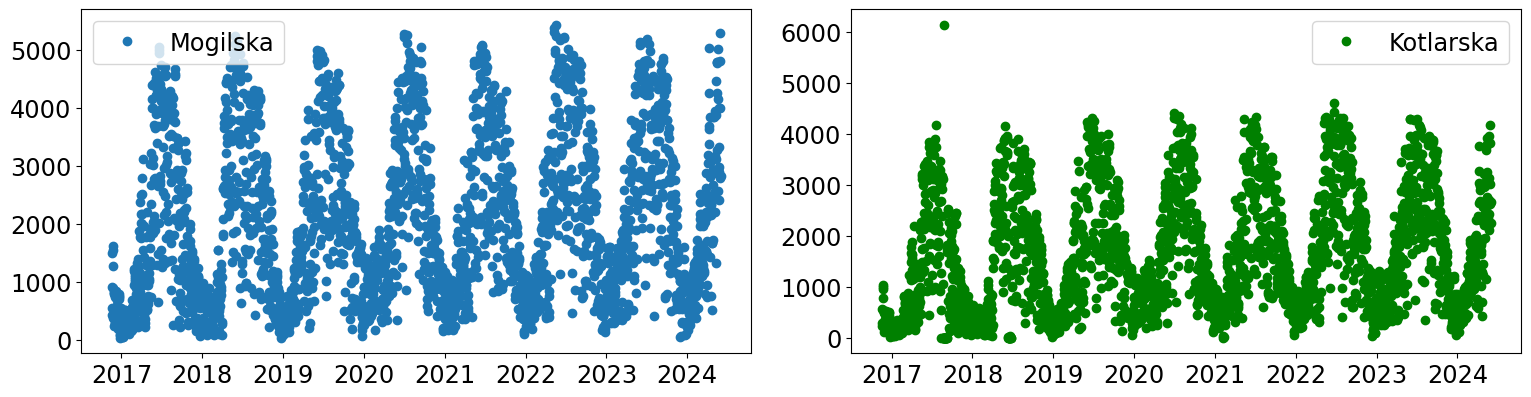

In [5]:
#BEGIN_SOLUTION
fig, axes = plt.subplots(1,2, figsize=(15,4))

axes[0].plot(df.index, df[train_street], 'o', label=train_street);
axes[1].plot(df.index, df[val_street], 'go', label=val_street);
axes[0].legend()
axes[1].legend()
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.15)
#END_SOLUTION
pass


**Proszę:**

Napisać funkcję `makeDataset(df, sequenceColumns, window_size, scale)` która przyjmuje obiekt `pandas.DataFrame` i zwraca obiekt `tf.Data.Dataset`.
Funkcja wykonuje następujące przekształcenia:

* dzieli dane na ciągi zliczeń z `window_size` dni
* normalizuje zliczenia o czynnik `1/scale`
* dzieli wiersze na `etykiety`: zliczenia z ostatniego dnia i `cechy`: zliczenia z wcześniejszych `window_size-1` dni
* dzieli zbiór na paczki o rozmiarze `16` i zachowuje go w pamięci podręcznej

**Wskazówki:**
* macierz danych z kolumny zbioru pandas można wyłuskać jako `df[...].values` lub podać po prostu `df[...]`
* macierze importujemy do `tf.data.Dataset` używając metody `from_tensor_slices(...)`

In [6]:
import datetime

#BEGIN_SOLUTION
def makeDataset(df, sequenceColumns, window_size, scale):

    slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size, axis=0)
    dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(df[sequenceColumns]/scale))
    dataset = dataset.map(lambda x: tf.reshape(x, (window_size, len(sequenceColumns)))).map(lambda y: (y[:-1,:], y[-1,:])).batch(16).cache()  
    return dataset
#END_SOLUTION

x = makeDataset(df, [train_street], window_size=2, scale=1)
for item in x.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0], end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0])

Features: [907.] Labels: [438.]
Features: [291.] Labels: [734.]
Features: [788.] Labels: [759.]
Features: [369.] Labels: [60.]


2024-06-12 08:52:35.028923: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-12 08:52:35.029319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Korzystając z funkcji `makeDataset(...)` proszę:

* utworzyć zbiory `train_dataset` i `val_dataset` ze zliczeniami z odpowiednich ulic.
* zbiór treningowy prosze ograniczyć do okresu `2017 - 2020`, a walidacyjny do okresu `2021 - 2023`
* szerokość okna ustawić na `32` dni
* skalę ustawić na `10_000`
* wypisać na ekran pierwsze 4 przykłady ze zbioru treningowego

**Wskazówka:**
* ograniczenie zakresu dat można uzyskać wybierając odpowiedni zakres wierszy w obiekcie `pandas.DataFrame` podawanym jako argument funkcji

In [7]:
window_size = 32
scale = 10_000

#BEGIN_SOLUTION
train_sequence_Columns = [train_street]
minTrainDate = datetime.date(2017, 1, 1)
maxTrainDate = datetime.date(2020, 12, 31)
train_dataset = makeDataset(df[minTrainDate:maxTrainDate], train_sequence_Columns, window_size, scale)

val_sequence_Columns = [val_street]
minValDate = datetime.date(2021, 1, 1)
maxValDate = datetime.date(2023, 12, 31)
val_dataset = makeDataset(df[minValDate:maxValDate], val_sequence_Columns, window_size, scale)

for item in train_dataset.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0]*scale, end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0]*scale)
#END_SOLUTION
pass

Features: [172. 495. 414. 411. 369.  60.  55.  86. 326. 387. 366. 394. 479. 191.
 125. 514. 519. 445. 435. 407. 192. 148. 484. 449. 501. 479. 447. 173.
 125. 331. 373.] Labels: [395.]
Features: [519. 445. 435. 407. 192. 148. 484. 449. 501. 479. 447. 173. 125. 331.
 373. 395. 353. 374. 156. 112. 423. 406. 406. 383. 405. 169. 157. 368.
 449. 526. 569.] Labels: [411.]
Features: [ 353.  374.  156.  112.  423.  406.  406.  383.  405.  169.  157.  368.
  449.  526.  569.  411.  175.  189.  692.  449.  571.  512.  547.  278.
  290. 1199. 1224.  947. 1083. 1129. 1013.] Labels: [1046.]
Features: [ 175.  189.  692.  449.  571.  512.  547.  278.  290. 1199. 1224.  947.
 1083. 1129. 1013. 1046.  786. 1160. 1139.  897.  961.  668.  346. 1056.
 1324. 1220. 1293. 1390.  233.  548. 1112.] Labels: [1883.]


2024-06-12 08:52:35.092498: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-06-12 08:52:35.092966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Proszę:**

* zbudować model z warstwami LSTM:
    * warstwa LSTM, `8` neuronów, zwracająca sekwencję
    * warstwa LSTM, `8` neuronów, zwracająca tylko ostatni element sekwencji
    * warstwa gęsta, `1` neuron
* wypisać na ekran podsumowanie modelu    

In [8]:
#BEGIN_SOLUTION
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None,1)),
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1, activation='sigmoid')],
                         name="traffic_prediction")  
model.summary()
#END_SOLUTION
pass

Model: "traffic_prediction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 8)        │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 873 (3.41 KB)

 Trainable params: 873 (3.41 KB)

 Non-trainable params: 0 (0.00 B)

**Proszę:**

* przeprowadzić trening modelu przez `150` epok Trening powinien zawierać standardowe elementy:
    * harmonogram zmiany współczynnika uczenia
    * wywołanie wczesnego zatrzymania 
    * rysowane historii funkcji straty
* kod trenowania zawrzeć w funkcji `trainModel(model, train_dataset, val_dataset)`


Epoch 219: early stopping
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0050  
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039   
CPU times: user 2min 5s, sys: 5.86 s, total: 2min 11s
Wall time: 1min 49s


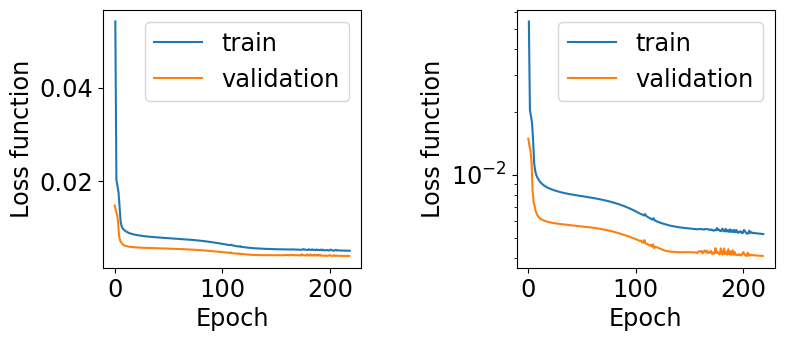

In [9]:
%%time

def trainModel(model, train_dataset, val_dataset):
#BEGIN_SOLUTION
    initial_learning_rate = 1E-3
    nStepsPerEpoch = train_dataset.cardinality().numpy()
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                    decay_steps=nStepsPerEpoch*100,
                    decay_rate=0.95,
                    staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                  loss='mse', metrics=[])

    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1)
    callbacks = [early_stop_callback]             

    history = model.fit(train_dataset, 
                        validation_data=val_dataset,
                        callbacks=callbacks,
                        epochs=4*150, verbose=0)
    model.evaluate(train_dataset)
    model.evaluate(val_dataset)
    plf.plotTrainHistory(history)
    return model
#END_SOLUTION

model = trainModel(model, train_dataset, val_dataset)

**Proszę:**

Dokończyć funkcję  `plotPrediction(...)`, która wykonuje rysunki kontrolne dla podanych ulic.
Dla każdej ulicy są rysowane:


* liczby zliczeń rzeczywista i prognozowaną dla okresu `2021.07.01 - 2021.07.31`
* iloraz `rzeczywista/prognozowana` dla okresu `2021 - 2023`
* histogram `(rzeczywista-prognozowana)/rzeczywista` z przedziałami zadanymi przez `bins=np.linspace(-2,2,50)`
* histogram`(rzeczywista-prognozowana)/rzeczywista` dla modelu prognozowania naiwnego: `jutro będzie tak jak dziś`
* histogramy są rysowane na jednym panelu


**Wskazówki:**
* zakresy dat można na wykresie można kontrolować w następujący sposób:
```Python
axes[index,0].set_xlim([datetime.date(2021, 7, 1), datetime.date(2021, 7, 31)])
axes[index,0].xaxis.set_major_locator(mdates.DayLocator(interval=14))
axes[index,0].xaxis.set_minor_locator(mdates.DayLocator())
```
* do uzyskania modelu naiwnego można użyć funkcji `np.roll()`


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/tmp/ipykernel_8724/2746659070.py:36: RuntimeWarning: divide by zero encountered in divide
  counts, _, _ = axes[index,2].hist((y-y_pred)/y, bins=np.linspace(-2,2,50), label="RNN")
/tmp/ipykernel_8724/2746659070.py:37: RuntimeWarning: divide by zero encountered in divide
  axes[index,2].hist((y-y_pred_naive)/y, bins=np.linspace(-2,2,50), label="Naive", alpha=0.7)


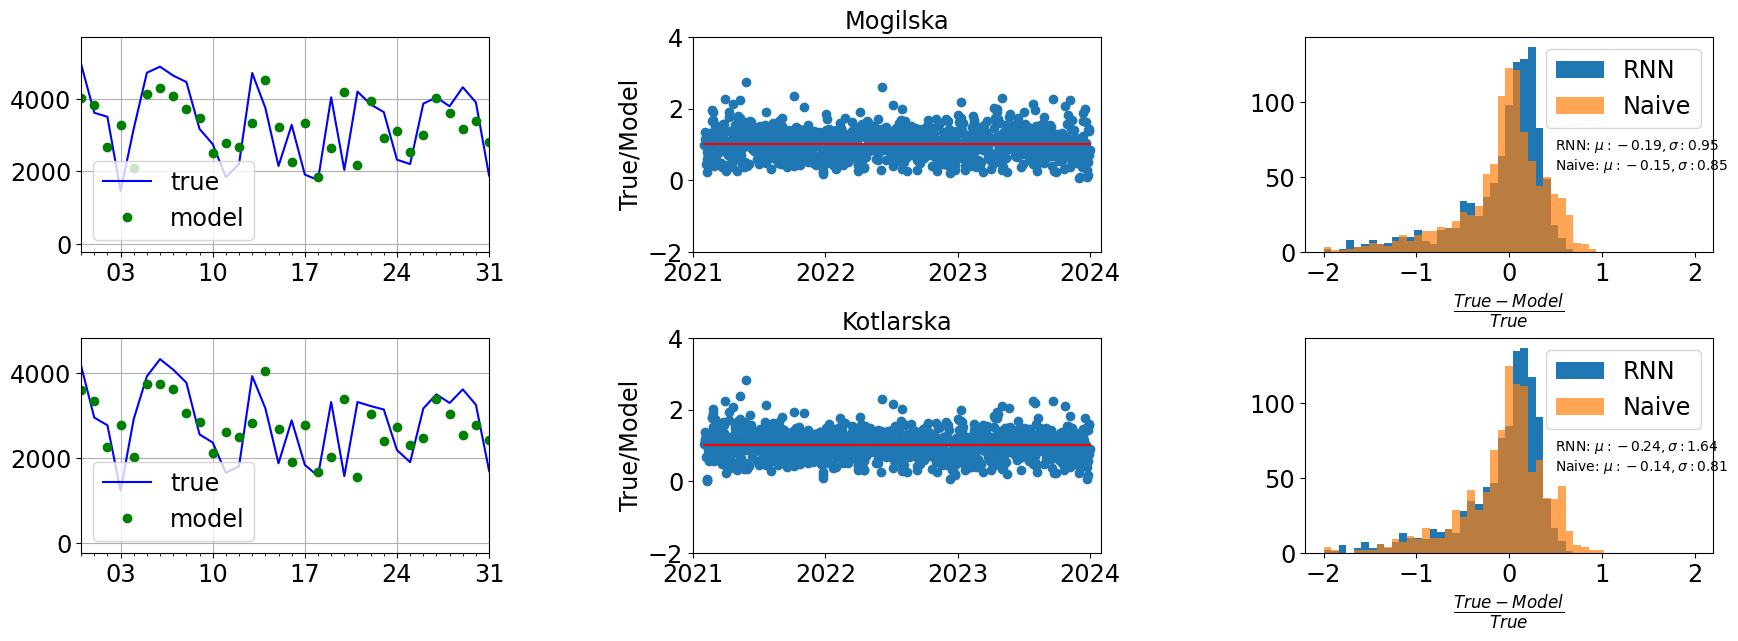

In [10]:
def plotPrediction(model, df, makeDataset, streets, window_size, scale):

    fig, axes = plt.subplots(2,3, figsize=(17,6))
    import matplotlib.dates as mdates

    for index,street in enumerate(streets[:2]):
        df_tmp = df[minValDate:maxValDate]
        dataset = makeDataset(df=df_tmp, sequenceColumns=[street], 
                              window_size=window_size, 
                              scale=scale)
        date = df_tmp.index[window_size-1:]
        y = df_tmp[street][window_size-1:].values
        #BEGIN_SOLUTION
        y_pred = model.predict(dataset)[:,0]*scale
        y_pred_naive = np.roll(y,1)
        ##
        axes[index,0].plot(date, y, 'b', label="true");
        axes[index,0].plot(date, y_pred, 'go', label="model");
        axes[index,0].set_xlim([datetime.date(2021, 6, 30), datetime.date(2021, 7, 31)])
        axes[index,0].xaxis.set_major_locator(mdates.DayLocator(interval=7))
        axes[index,0].xaxis.set_minor_locator(mdates.DayLocator())
        axes[index,0].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        axes[index,0].legend()
        axes[index,0].grid(True)
        ##
        axes[index,1].set_title(street)
        axes[index,1].plot(date, y/y_pred, 'o', label="true");
        axes[index,1].plot([date.min(), date.max()], [1,1], 'r')
        axes[index,1].set_xlim([datetime.date(2021, 1, 1), datetime.date(2024, 1, 31)])
        axes[index,1].set_ylim([-2,4])
        axes[index,1].xaxis.set_major_locator(mdates.YearLocator(base=1))
        axes[index,1].xaxis.set_minor_locator(mdates.YearLocator())
        axes[index,1].set_ylabel("True/Model")
        #END_SOLUTION
        ##
        counts, _, _ = axes[index,2].hist((y-y_pred)/y, bins=np.linspace(-2,2,50), label="RNN")
        axes[index,2].hist((y-y_pred_naive)/y, bins=np.linspace(-2,2,50), label="Naive", alpha=0.7)
        axes[index,2].set_xlabel(r"$\frac{True-Model}{True}$")
        pull = np.divide((y-y_pred).astype(float), y, out=np.zeros_like(y, dtype=float), where=y>0)
        mean = np.mean(pull)
        std = np.std(pull)
        axes[index,2].text(0.5, 0.5*counts.max(), r"RNN: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean, std))
        pull = np.divide((y-y_pred_naive), y, out=np.zeros_like(y, dtype=float), where=y>0)
        mean = np.mean(pull)
        std = np.std(pull)
        axes[index,2].text(0.5, 0.4*counts.max(), r"Naive: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean, std))
        axes[index,2].legend()
        ##
        opadyColumn = "suma opadu dzień  [mm]"
        if opadyColumn in df.columns:
            ax2 = axes[index,0].twinx()
            ax2.plot(date, df_tmp[opadyColumn][window_size-1:], 'r');  
            ax2.tick_params(axis='y', labelcolor="r")
            ax2.yaxis.label.set_color('red')
            ax2.set_ylabel("Day rain fall\n [arb. units]")
    ##
    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.5, hspace=0.4)
    #END_SOLUTION

plotPrediction(model, df, makeDataset, [train_street, val_street], window_size, scale)

Zobaczmy czy dodanie danych o pogodzie poprawi wydajność modelu. Jako substytutu prognozy pogody użyjemy aktualnych danych pogodowych z dnia na który jest wykonywane przewidywanie ruchu rowerzystów.

Źródłem danych meteorologicznych jest Instytut Meteorologii i Gospodarki Wodnej – Państwowy Instytut Badawczy”.
Dane o warunkach pogodowych pobierzemy z portalu [IMGW](https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/).
Skorzystamy ze stacji Kraków-Balice.

In [11]:
import subprocess

# dowlnoad data
for year in range(2016, 2024):
    url = f"https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/{year}/{year}_566_s.zip"
    subprocess.run(["wget", url, "-P", "../data/Pogoda/"])

# unzip data
subprocess.run(["unzip","../data/Pogoda/*_566_s.zip", "-d","../data/Pogoda/"])

#remove zip archives
#file list expansion from * dos not work with subprocess
!rm -f ../data/Pogoda/*zip*

--2024-06-12 08:54:26--  https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/2016/2016_566_s.zip
Resolving danepubliczne.imgw.pl (danepubliczne.imgw.pl)... 91.220.17.226
Connecting to danepubliczne.imgw.pl (danepubliczne.imgw.pl)|91.220.17.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15456 (15K) [application/zip]
Saving to: ‘../data/Pogoda/2016_566_s.zip.2’

     0K .......... .....                                      100%  172M=0s

2024-06-12 08:54:28 (172 MB/s) - ‘../data/Pogoda/2016_566_s.zip.2’ saved [15456/15456]

--2024-06-12 08:54:28--  https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/2017/2017_566_s.zip
Resolving danepubliczne.imgw.pl (danepubliczne.imgw.pl)... 91.220.17.226
Connecting to danepubliczne.imgw.pl (danepubliczne.imgw.pl)|91.220.17.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15579 (15K) [application/zip]
Sav

Archive:  ../data/Pogoda/2022_566_s.zip

Archive:  ../data/Pogoda/2023_566_s.zip

Archive:  ../data/Pogoda/2019_566_s.zip

Archive:  ../data/Pogoda/2018_566_s.zip

Archive:  ../data/Pogoda/2017_566_s.zip

Archive:  ../data/Pogoda/2021_566_s.zip

Archive:  ../data/Pogoda/2016_566_s.zip

Archive:  ../data/Pogoda/2020_566_s.zip


--2024-06-12 08:54:29--  https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/2023/2023_566_s.zip
Resolving danepubliczne.imgw.pl (danepubliczne.imgw.pl)... 91.220.17.226
Connecting to danepubliczne.imgw.pl (danepubliczne.imgw.pl)|91.220.17.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15256 (15K) [application/zip]
Saving to: ‘../data/Pogoda/2023_566_s.zip.2’

     0K .......... ....                                       100%  261M=0s

2024-06-12 08:54:29 (261 MB/s) - ‘../data/Pogoda/2023_566_s.zip.2’ saved [15256/15256]

replace ../data/Pogoda/s_d_566_2022.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)

7 archives were successfully processed.
1 archive had warnings but no fatal errors.


Dane załadujemy do obiektu Pandas dataframe.

**Proszę:**

Dokończyć funkcję `makeDataFrame(filePath)`, która wczytuje dane z pliku csv i tworzy obiekt `pandas.DataFrame`.
Funkcja wykonuje następujące operacje:

* wczytuje jedynie kolumny `2-22`
* używa kolumn `2-4` do utworzenia daty
* używa kodowania `Latin-1`
* usuwa kolumny zawierające `NaN`
* ustawia nazwy kolumn


In [12]:
import pandas as pd

def makeDataFrame(filePath):
    columns = ["Data","zachmurzenie", 
               "prędkość wiatru [m/s]", "temperatura [°C]",
               "ciśnienie pary wodnej [hPa]", "wilgotność względna [%]",             
                "ciśnienie na poziomie stacji [hPa]", "ciśnienie na poziomie morza [hPa]",      
                "suma opadu dzień  [mm]","suma opadu noc   [mm]"]    
#BEGIN_SOLUTION
    df = pd.read_csv(filePath,header=None,
                     sep=",", usecols = np.arange(2, 22),
                     parse_dates=[[2,3,4]], 
                     encoding='Latin1').dropna(axis=1)
    df.columns = columns
#END_SOLUTION    
    return df

files = glob.glob("../data/Pogoda/s_d_t*.csv")
df_pogoda = pd.concat([makeDataFrame(file) for file in files])
df_pogoda.describe()

/tmp/ipykernel_8724/3619319591.py:10: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(filePath,header=None,


TypeError: Argument 'i' has incorrect type (expected int, got numpy.int64)

Połączymy obiekty dataframe z danymi o zliczeniach i pogodzie. Dla obu zbiorów ustawiamy datę jako indeks - dzięki temu zapewnimy synchronizację wiersze między oboma zbiorami.

In [ ]:
#BEGIN_SOLUTION
# set date as a index
df_pogoda.index = df_pogoda["Data"]

# drop index columns from weather df to avoid duplication
df_pogoda.drop(columns=["Data"], inplace=True)

# merge two dataframes. Only common dates are kept
df_merged = df.join(df_pogoda, how="inner")
#END_SOLUTION
df_merged.describe()

**Proszę:**

Napisać funkcję `makeDataset(df, sequenceColumns, featureColumns, window_size, scale)` która przygotowuje obiekt `tf.data.Dataset` z 
danymi o zliczeniach - `sequenceColumns` i pogodzie - `featureColumns`. 

Funkcja wykonuje następujące operacje:

* wczytuje dane z pandas DataFrame do `tf.data.Dataset`
* dzieli dane na okna o długości `window_size`
* dzieli wiersz danych na krotkę krotek: `((sekwencja zliczeń dla przeszłych dni, dane pogodowe dla danego dnia), zliczenia dla danego dnia)`

**Wskazówki:**

* jako listę kolumn wybieranych z obiektu `pandas.DataFrame` można podać 
```Python
columns = sequenceColumns+featureColumns
```

* wszystkie dane wejściowe można podzielić na sekwencje o długości `window_size`, a potem z tej sekwencji wydzielić
  odpowiednie fragmenty. To o oznacza, że na początku sekwencja ma `inputDim = len(columns)` i trzeba z niej wydzielić dane
  o zliczeniach dla odpowiednich dni, etykietę i dane pogodowe

  Oczekiwany efekt dla paczki o rozmiarze 1:
  ```Python
  
  Features: (<tf.Tensor: shape=(1, 31, 1), dtype=float64, numpy=
array([[[1.72e-06],
        [4.95e-06],
        ...
        [3.73e-06]]])>, <tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[-0.00018,  0.     ,  0.0001 ]])>)
Labels: [3.95e-06]
  ```

In [ ]:
def makeDataset(df, sequenceColumns, featureColumns, window_size, scale):
#BEGIN_SOLUTION    
    slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size, axis=0)

    def features_label_split(dataRow):
        return (tf.reshape(dataRow[:-1,0:len(sequenceColumns)]/scale, (window_size-1, len(sequenceColumns))), dataRow[-1,len(sequenceColumns):]), dataRow[-1,0]/scale

    dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(df[sequenceColumns+featureColumns]))
    dataset = dataset.map(features_label_split).batch(16).cache()
#END_SOLUTION
    return dataset

df_merged["suma opadu dzień  [mm]"] = df_merged["suma opadu dzień  [mm]"]/40
df_merged["temperatura [°C]"] = df_merged["temperatura [°C]"]/30
df_merged["prędkość wiatru [m/s]"] = df_merged["prędkość wiatru [m/s]"]/10

featureColumns = ["temperatura [°C]","suma opadu dzień  [mm]","prędkość wiatru [m/s]"]
train_dataset = makeDataset(df_merged[minTrainDate:maxTrainDate], 
                            [train_street],
                            featureColumns,
                            window_size=window_size,
                            scale=scale)

val_dataset = makeDataset(df_merged[minValDate:maxValDate],
                            [val_street],
                            featureColumns,
                            window_size=window_size,
                            scale=scale)

item = next(iter(train_dataset))
print(colored("Features:","blue"), item[0])
print(colored("Labels:","blue"), item[1].numpy())

**Proszę:**

* wywołać funkcję `makeDataset(...)` z takimi parametrami by można było łatwo sprawdzić czy dane pogodowe są dobrze zsynchronizowane,
  tzn. dane o pogodzie pochodzą z dnia dla którego model ma przewidzieć zliczenia

* porównać wartości dla pierwszego przykładu w obiekcie `pandas.DataFrame` z odpowiednim przykładem z  `tf.data.Dataset` i sprawdzić czy ten ostatni jest dobrze zsynchronizowany

In [ ]:
#BEGIN_SOLUTION
x = makeDataset(df_merged, 
                [train_street],
                featureColumns,
                scale=1, window_size=2)
item = next(iter(x))
print(colored("Features:","blue"), item[0])
print(colored("Labels:","blue"), item[1].numpy())

#Print first 5 rows of the dataset to check if the TF and Pandas dataframes are aligned
df_merged[featureColumns+[train_street]].head()
#END_SOLUTION
pass

## Model nie sekwencyjny

Skonstruujemy model, który składa się z dwu gałęzi:
* analiza sekwencji - gałąź rekurencyjna
* analiza przewidzianych zliczeń i danych o pogodzie - gałąź gęsta

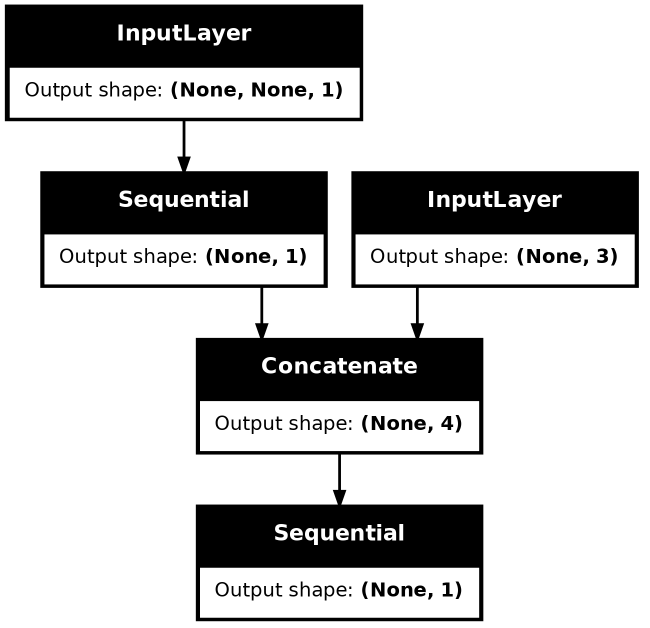

In [ ]:
# create input from counts
#BEIGN_SOLUTION
countsInputDim = 1
counts_input = tf.keras.Input(shape=(None, countsInputDim))

# create input from weather conditions
weatherInputDim = len(featureColumns)
weather_input = tf.keras.Input(shape=(weatherInputDim,))
#END_SOLUTION
pass

In [ ]:
# create LSTM blocks
#BEGIN_SOLUTION
sequence_analyzer = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, countsInputDim)),
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1, activation='sigmoid')],
                         name="sequence_analyzer")

# pass counts throught LSTM blocks
sequence_result = sequence_analyzer(counts_input)
#END_SOLUTION
pass

In [ ]:
#BEGIN_SOLUTION
# merge counts and weather data
merged_input = tf.keras.layers.Concatenate()([sequence_result, weather_input])

# create a FCC block
merged_analyzer = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(merged_input.shape[-1],)),
                                                 tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                                 tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                                 tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                                 tf.keras.layers.Dense(1, activation='sigmoid')],
                                                 name="merged_analyzer")
#END_SOLUTION
pass

In [ ]:
#BEGIN_SOLUTION
# pass merged data through dense layers
output = merged_analyzer(merged_input)

tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
# contruct a full model
model = tf.keras.Model(inputs=(counts_input, weather_input), outputs=output, name="TrafficPrediction")
model.summary()

# run model on trainig dataset to check if it works
model.predict(train_dataset);
#END_SOLUTION
pass

**Proszę:**

* przeprowadzić trening modelu z danymi meteorologicznymi
* narysować rysunki kontrolne
* porównać jakość wyniku z poprzednim modelem

**Wskazówka:**
* nowa wersja funkcji `makeDataset(...)` bierze dodatkowy argument - `featureColumns`.
 Korzystając z `functools.partial(...)` można nadać temu argumentowi
  wartość i przekazać do funkcji rysującej wersję  `makeDataset(...)`, która nie będzie wymagała tego dodatkowego argumentu

In [ ]:
#BEGIN_SOLUTION
model = trainModel(model, train_dataset, val_dataset)
makeDataset_tmp = functools.partial(makeDataset, featureColumns=featureColumns)
plotPrediction(model, df_merged, makeDataset_tmp, [train_street, val_street], window_size, scale)
#END_SOLUTION
pass

# Zadanie domowe

**Proszę:**

* dodać do obiektu `pandas.DataFrame` kolumnę z numerem tygodnia
* skonstruować model, który jako sekwencje wejściowe będzie brał dane z ulic:
    ```Python
    ["Mogilska", "Kotlarska", "Bulwary", "Wadowicka", "Wielicka"]
    ```
   oraz numer dnia tygodnia
* jako dane o pogodzie będzie przyjmował kolumny `suma opadu dzień  [mm]` i `temperatura [°C]`
* przyjąć że pierwsza ulica z listy to ulica, dla której jest liczona prognoza
* zbiór treningowy ograniczyć do okresu `2017 - 2020`
* zbiór walidacyjny ograniczyć do okresu `2021 - 2023`
* sprawdzić czy dane w obiekcie `tf.data.Dataset` są dobrze przygotowane
* przeprowadzić trening
* narysować rysunki kontrolne dla ulicy `Mogilskiej` (takie jak na wykładzie)
    * górny wiersz dla zakresu `01.05.2023 - 31.07.2023`
    * dolny dla zakresu `0.10.10.2023 - 31.12.2023`
* przeprowadzić trening dla różnych szerokości okna czasowego i wskazać dającą najlepsze. Jako metryki użyć `średniego błedu kwadratowego` na zbiorze walidacyjnym. 

In [ ]:
# add day of week to data
#BEGIN_SOLUTION
df_merged["Dzień tygodnia"] = df_merged.index.dayofweek
#END_SOLUTION
pass

In [ ]:
# prepare traion and validation datasets
#BEGIN_SOLUTION 
window_size = 128
featureColumns = ["suma opadu dzień  [mm]", "temperatura [°C]"]
streets = ["Mogilska", "Kotlarska", "Bulwary", "Wadowicka", "Wielicka", "Dzień tygodnia"]

train_dataset = makeDataset(df_merged[minTrainDate:maxTrainDate], 
                            streets,
                            featureColumns,
                            window_size=window_size,
                            scale=scale)

val_dataset = makeDataset(df_merged[minValDate:maxValDate],
                            streets,
                            featureColumns,
                            window_size=window_size,
                            scale=scale)

#END_SOLUTION
item = next(iter(train_dataset))
print(colored("Features:","blue"), item[0])
print(colored("Labels:","blue"), item[1].numpy())

In [ ]:
# check if the data is aligned
#BEGIN_SOLUTION
x = makeDataset(df_merged, 
                streets,
                featureColumns,
                scale=1, window_size=2)
item = next(iter(x))
print(colored("Features:","blue"), item[0])
print(colored("Labels:","blue"), item[1].numpy())

#Print first 5 rows of the dataset to check if the TF and Pandas dataframes are aligned
df_merged[featureColumns+streets].head()
#END_SOLUTION
pass

In [ ]:
# contruct model
#BEGIN_SOLUTION
#create input from counts
countsInputDim = len(streets)
counts_input = tf.keras.Input(shape=(None, countsInputDim))

#create input from weather conditions
weatherInputDim = len(featureColumns)
weather_input = tf.keras.Input(shape=(weatherInputDim,))

#create LSTM blocks
sequence_analyzer = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, countsInputDim)),
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1, activation='tanh')],
                         name="sequence_analyzer")

#pass counts throught LSTM blocks
sequence_result = sequence_analyzer(counts_input)

#merge counts and weather data
merged_input = tf.keras.layers.Concatenate()([sequence_result, weather_input])

#create a FCC block
merged_analyzer = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(merged_input.shape[-1],)),
                                                 tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                                 tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                                 tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                                                 tf.keras.layers.Dense(1, activation='sigmoid')],
                                                 name="merged_analyzer")

#pass merged data through dense layers
output = merged_analyzer(merged_input)

tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
#contruct a full model
model = tf.keras.Model(inputs=(counts_input, weather_input), outputs=output, name="TrafficPrediction")
model.summary()

#END_SOLUTION
#Run model on trainig dataset to check if it works
model.predict(train_dataset);

In [ ]:
# prepare plotting function
#BEGIN_SOLUTION
def plotPrediction(model, df, streets, makeDataset, window_size, scale):

    fig, axes = plt.subplots(2,3, figsize=(17,6))
    import matplotlib.dates as mdates

    startDate = [datetime.date(2021, 5, 1), datetime.date(2021, 10, 1)]
    endDate = [datetime.date(2021, 7, 31), datetime.date(2021, 12, 31)]

    for index in range(2):
        dataset = makeDataset(df=df, sequenceColumns=streets, 
                              window_size=window_size, 
                              scale=scale)
        date = df.index[window_size-1:]
        y = df[streets[0]][window_size-1:]
        y_pred = model.predict(dataset)[:,0]*scale
        y_pred_naive = np.roll(y,1)
        #filter dates
        mask = (date >= np.datetime64(startDate[index])) & (date <= np.datetime64(endDate[index]))
        date = date[mask]
        y = y[mask]
        y_pred = y_pred[mask]
        y_pred_naive = y_pred_naive[mask]
        ##
        axes[index,1].set_title(startDate[index].strftime("%Y-%m-%d")+" - "+endDate[index].strftime("%Y-%m-%d"))
        ##
        axes[index,0].plot(date, y, 'b', label="true");
        axes[index,0].plot(date, y_pred, 'go', label="model");
        axes[index,0].xaxis.set_major_locator(mdates.DayLocator(interval=14))
        axes[index,0].xaxis.set_minor_locator(mdates.DayLocator())
        axes[index,0].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        #axes[index,0].legend()
        axes[index,0].grid(True)
        ##
        axes[index,1].plot(date, y/y_pred, 'o', label="true");
        axes[index,1].plot([date.min(), date.max()], [1,1], 'r')
        axes[index,1].set_ylim([-2,4])
        axes[index,1].xaxis.set_major_locator(mdates.DayLocator(interval=14))
        axes[index,1].xaxis.set_minor_locator(mdates.DayLocator())
        axes[index,1].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
        axes[index,1].set_ylabel("True/Model")
        ##
        counts, _, _ = axes[index,2].hist((y-y_pred)/y, bins=np.linspace(-2,2,50), label="RNN")
        axes[index,2].hist((y-y_pred_naive)/y, bins=np.linspace(-2,2,50), label="Naive", alpha=0.7)
        axes[index,2].set_xlabel(r"$\frac{True-Model}{True}$")
        pull = np.divide((y-y_pred).astype(float), y, out=np.zeros_like(y, dtype=float), where=y>0)
        mean = np.mean(pull)
        std = np.std(pull)
        axes[index,2].text(0.5, 0.5*counts.max(), r"RNN: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean, std))
        pull = np.divide((y-y_pred_naive), y, out=np.zeros_like(y, dtype=float), where=y>0)
        mean = np.mean(pull)
        std = np.std(pull)
        axes[index,2].text(0.5, 0.4*counts.max(), r"Naive: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean, std))
        axes[index,2].legend()
        ##
        weatherColumn = "suma opadu dzień  [mm]"
        weatherColumn = "temperatura [°C]"
        if weatherColumn in df.columns:
            ax2 = axes[index,0].twinx()
            ax2.plot(date, df[weatherColumn][window_size-1:][mask], 'or', markersize=2);  
            ax2.tick_params(axis='y', labelcolor="r")
            ax2.yaxis.label.set_color('red')
            ax2.set_ylabel(weatherColumn+"\n [arb. units]")
    ##
    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.5, hspace=0.4)
    #END_SOLUTION
    pass

In [ ]:
# train model and make control plots
#BEGIN_SOLUTION
model = trainModel(model, train_dataset, val_dataset)
makeDataset_tmp = functools.partial(makeDataset, featureColumns=featureColumns)
plotPrediction(model, df_merged, streets, makeDataset_tmp, window_size, scale)
#END_SOLUTION
pass